In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load LIAR-PLUS TSV file
columns = [
    'index', 'json_id', 'label', 'statement', 'subject', 'speaker', 'job_title',
    'state_info', 'party_affiliation', 'barely_true', 'false',
    'half_true', 'mostly_true', 'pants_on_fire', 'context',
    'justification'
]
train_data = pd.read_csv('train2.tsv', sep='\t', header=None, names=columns)
test_data = pd.read_csv('test2.tsv', sep='\t', header=None, names=columns)
val_data = pd.read_csv('val2.tsv', sep='\t', header=None, names=columns)

In [ ]:
print(train_data['label'].value_counts())
print("Unique labels:", train_data['label'].unique())

label
half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: count, dtype: int64
Unique labels: ['false' 'half-true' 'mostly-true' 'true' 'barely-true' 'pants-fire']


In [ ]:
# Combine statement and justification
train_data['full_text'] = train_data['statement'].astype(str) + " " + train_data['justification'].astype(str)
test_data['full_text'] = test_data['statement'].astype(str) + " " + test_data['justification'].astype(str)
val_data['full_text'] = val_data['statement'].astype(str) + " " + val_data['justification'].astype(str)

# Prepare X and y
X_train = train_data['full_text']
y_train = train_data['label']

X_test = test_data['full_text']
y_test = test_data['label']

X_val = val_data['full_text']
y_val = val_data['label']

In [ ]:
# Drop rows with missing labels or text
train_data.dropna(subset=['label', 'full_text'], inplace=True)
test_data.dropna(subset=['label', 'full_text'], inplace=True)
val_data.dropna(subset=['label', 'full_text'], inplace=True)

# Filter only selected labels
valid_labels = ['true', 'false', 'half-true', 'barely-true', 'pants-fire', 'mostly-true']
train_data = train_data[train_data['label'].isin(valid_labels)]
test_data = test_data[test_data['label'].isin(valid_labels)]
val_data = val_data[val_data['label'].isin(valid_labels)]

In [ ]:
# Varify labels
print(train_data['label'].value_counts())
print("Unique labels in train:", train_data['label'].unique())

label
half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: count, dtype: int64
Unique labels in train: ['false' 'half-true' 'mostly-true' 'true' 'barely-true' 'pants-fire']


In [ ]:
# Clean text
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # remove links
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)  # remove special chars
    text = re.sub(r"\s+", " ", text)  # collapse spaces
    return text.strip().lower()

train_data.loc[:, 'clean_text'] = train_data['full_text'].apply(clean_text)
test_data.loc[:, 'clean_text'] = test_data['full_text'].apply(clean_text)
val_data.loc[:, 'clean_text'] = val_data['full_text'].apply(clean_text)

In [ ]:
X_train = train_data['clean_text']
X_test = test_data['clean_text']
X_val = val_data['clean_text']

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_data['label'])
y_test_encoded = label_encoder.transform(test_data['label'])
y_val_encoded = label_encoder.transform(y_val)

num_classes = len(label_encoder.classes_)
print("Number of classes:", num_classes)

Number of classes: 6


In [ ]:
# Tokenize the text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [ ]:
# Pad sequences
maxlen = 250
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen)

In [ ]:
# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Convert to one-hot
y_train_cat = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_cat = to_categorical(y_test_encoded, num_classes=num_classes)
y_val_cat = to_categorical(y_val_encoded, num_classes=num_classes)

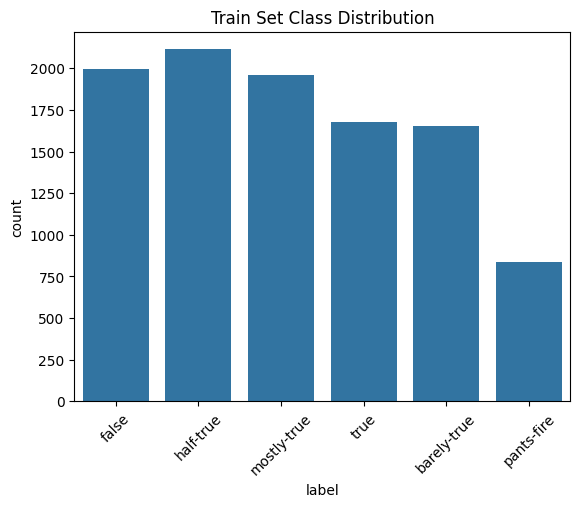

In [ ]:
sns.countplot(x=train_data['label'])
plt.title("Train Set Class Distribution")
plt.xticks(rotation=45)
plt.show()

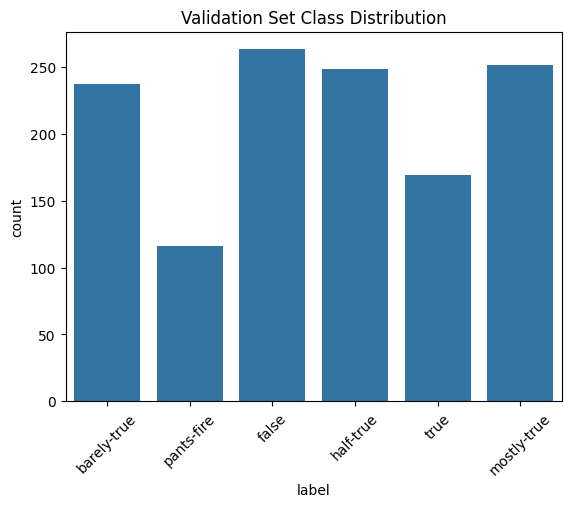

In [ ]:
sns.countplot(x=val_data['label'])
plt.title("Validation Set Class Distribution")
plt.xticks(rotation=45)
plt.show()

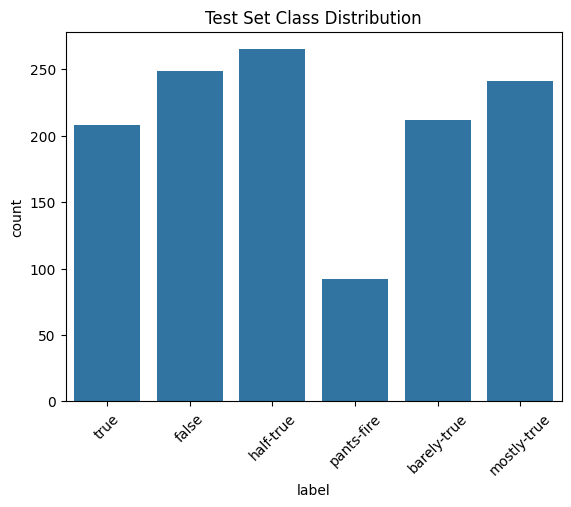

In [ ]:
sns.countplot(x=test_data['label'])
plt.title("Test Set Class Distribution")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Input layer
input_layer = Input(shape=(maxlen,))

In [ ]:
# Load GloVe embeddings
GLOVE_FILE = 'glove.6B.100d.txt'
embedding_dim = 100

embedding_index = {}
with open(GLOVE_FILE, encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        if len(vector) == embedding_dim:  # ensure match
            embedding_index[word] = vector

In [ ]:
# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None and len(embedding_vector) == embedding_dim:
            embedding_matrix[i] = embedding_vector

In [ ]:
embedded_input = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=maxlen,
    trainable=True
)(input_layer)

In [ ]:
# BiLSTM branch
lstm = Bidirectional(LSTM(32, return_sequences=True))(embedded_input)
lstm = GlobalMaxPooling1D()(lstm)

In [ ]:
# CNN branch
cnn = Conv1D(filters=64, kernel_size=5, activation='relu')(embedded_input)
cnn = GlobalMaxPooling1D()(cnn)

In [ ]:
# Concatenate outputs
combined = Concatenate()([lstm, cnn])
combined = Dropout(0.6)(combined)
output = Dense(num_classes, activation='softmax')(combined)

In [ ]:
# Output layer
output = Dense(num_classes, activation='softmax')(combined)

In [ ]:
# Build model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

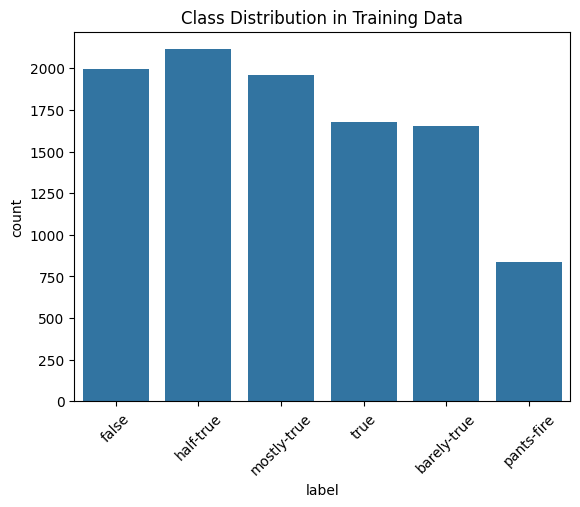

In [ ]:
# Check class balance
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=train_data['label'])
plt.xticks(rotation=45)
plt.title("Class Distribution in Training Data")
plt.show()

In [ ]:
# Compute class weight
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)

# Convert to dictionary for Keras
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(1.0318419991938734), 1: np.float64(0.8554720133667502), 2: np.float64(0.8073163040050457), 3: np.float64(0.8698606863744478), 4: np.float64(2.0341676599125944), 5: np.float64(1.0182975338106603)}


In [ ]:
# Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 250, 100)  │  2,590,200 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 250, 64)   │     34,048 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 246, 64)   │     32,064 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ bidirectional[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 6)         │        774 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,657,086 (10.14 MB)

 Trainable params: 2,657,086 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [ ]:
# Last layer should be:
Dense(6, activation='softmax')  # for 6 classes

# Compile with:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Model fitting
history = model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_val_pad, y_val_cat),
    epochs=10,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 71s 412ms/step - accuracy: 0.1707 - loss: 2.0343 - val_accuracy: 0.2134 - val_loss: 1.7822
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 80s 404ms/step - accuracy: 0.2085 - loss: 1.7760 - val_accuracy: 0.2087 - val_loss: 1.7795
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 64s 398ms/step - accuracy: 0.2456 - loss: 1.7451 - val_accuracy: 0.1916 - val_loss: 1.7876
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 84s 409ms/step - accuracy: 0.2599 - loss: 1.7108 - val_accuracy: 0.1900 - val_loss: 1.7844


In [ ]:
# Make predictions
pred_probs = model.predict(X_test_pad)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = np.argmax(y_test_cat, axis=1)

# Decode back to labels
pred_labels = label_encoder.inverse_transform(pred_classes)
true_labels = label_encoder.inverse_transform(true_classes)

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step


In [ ]:
# Classification
from sklearn.metrics import classification_report
import numpy as np

y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


print(classification_report(true_labels, pred_labels))

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step
              precision    recall  f1-score   support

 barely-true       0.17      0.15      0.16       212
       false       0.20      0.31      0.24       249
   half-true       0.19      0.15      0.17       265
 mostly-true       0.27      0.15      0.19       241
  pants-fire       0.16      0.21      0.18        92
        true       0.22      0.24      0.23       208

    accuracy                           0.20      1267
   macro avg       0.20      0.20      0.20      1267
weighted avg       0.21      0.20      0.20      1267

              precision    recall  f1-score   support

 barely-true       0.17      0.15      0.16       212
       false       0.20      0.31      0.24       249
   half-true       0.19      0.15      0.17       265
 mostly-true       0.27      0.15      0.19       241
  pants-fire       0.16      0.21      0.18        92
        true       0.22      0.24      0.23       208

    accuracy                         

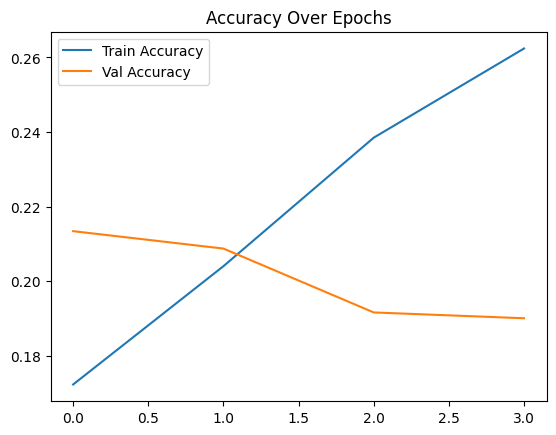

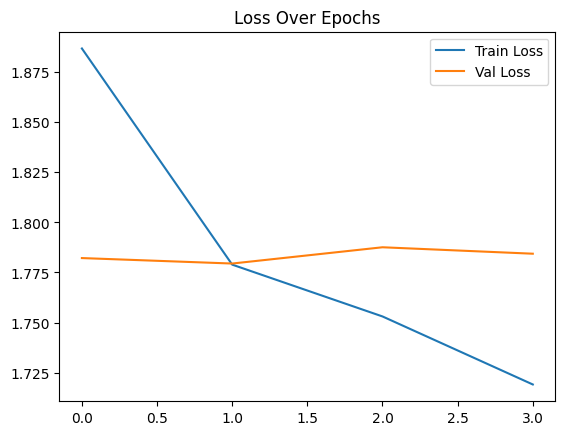

In [ ]:
# Visualize training process
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()